Each observation is one NHANES participant linked to mortality. The predictors are demographic and socioeconomic characteristics measured per participant, often a numeric value either straight up or assigned values to different outputs, and the outcomes are mortality status (MORTSTAT) and follow-up time in months (PERMTH_INT). The data were collected through NHANES and linked to mortality records to study long-term health outcomes. Missing data and coded nonresponse values may affect the analysis because k-NN requires complete predictors and is sensitive to the scale and is affected by missing data.

In [2]:
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.

In [3]:
import pandas as pd
import numpy as np

vars_use = [
    "MORTSTAT",
    "PERMTH_INT",
    "RIDAGEYR",
    "DMDMARTL",
    "INDFMPIR",
    "DMDHHSIZ",
    "DMDBORN"
]

df2 = df[vars_use].copy()

# replace common NHANES missing codes
missing_codes = [7, 9, 77, 99]
for col in ["DMDMARTL", "DMDBORN"]:
    df2[col] = df2[col].replace(missing_codes, np.nan)

df2.isna().sum()

MORTSTAT      4520
PERMTH_INT    4520
RIDAGEYR         0
DMDMARTL      3902
INDFMPIR      1483
DMDHHSIZ         0
DMDBORN         13
dtype: int64

In [4]:
df_model = df2.dropna().copy()
df_model.shape

(4117, 7)

For modeling, I used complete cases for the selected variables including househole-income, poverty rate, martial status, etc... I also dropped any missing values from the data. This simplifies the k-NN implementation, since k-NN cannot directly handle missing predictor values.

In [5]:
df_model.describe()

,MORTSTAT,PERMTH_INT,RIDAGEYR,DMDMARTL,INDFMPIR,DMDHHSIZ,DMDBORN
count,4117.000000,4117.000000,4117.000000,4117.000000,4.117000e+03,4117.000000,4117.000000
mean,0.297790,203.887297,46.639786,2.531941,2.424496e+00,3.246296,1.373330
std,0.457342,66.156582,20.641232,1.818077,1.607685e+00,1.686442,0.671724
min,0.000000,0.000000,18.000000,1.000000,5.397605e-79,1.000000,1.000000
25%,0.000000,203.000000,28.000000,1.000000,1.070000e+00,2.000000,1.000000
50%,0.000000,235.000000,44.000000,1.000000,1.990000e+00,3.000000,1.000000
75%,1.000000,243.000000,64.000000,5.000000,3.840000e+00,4.000000,2.000000
max,1.000000,250.000000,85.000000,6.000000,5.000000e+00,7.000000,3.000000


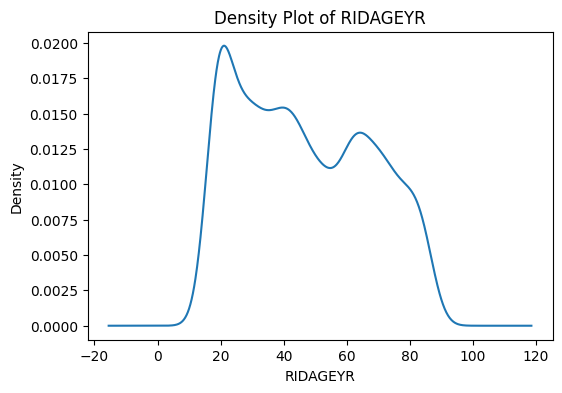

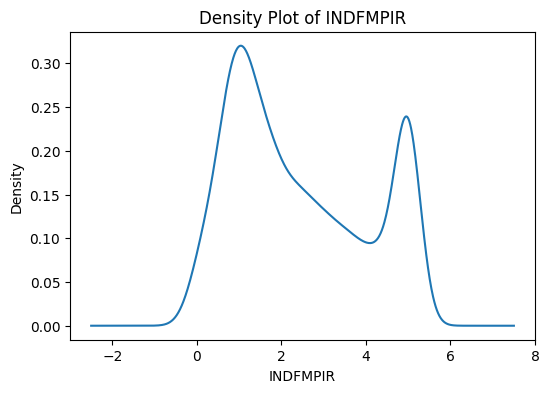

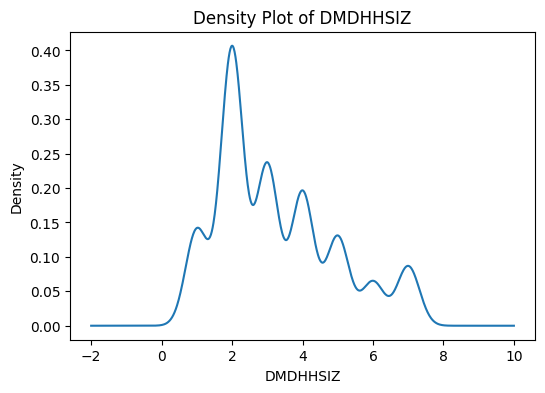

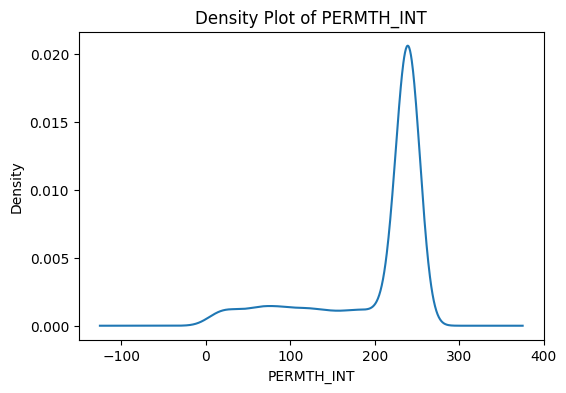

In [6]:
import matplotlib.pyplot as plt

num_vars = ["RIDAGEYR", "INDFMPIR", "DMDHHSIZ", "PERMTH_INT"]

for col in num_vars:
    plt.figure(figsize=(6,4))
    df_model[col].plot(kind="density")
    plt.title(f"Density Plot of {col}")
    plt.xlabel(col)
    plt.show()

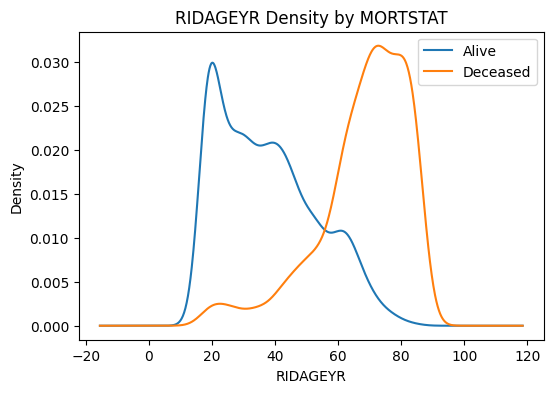

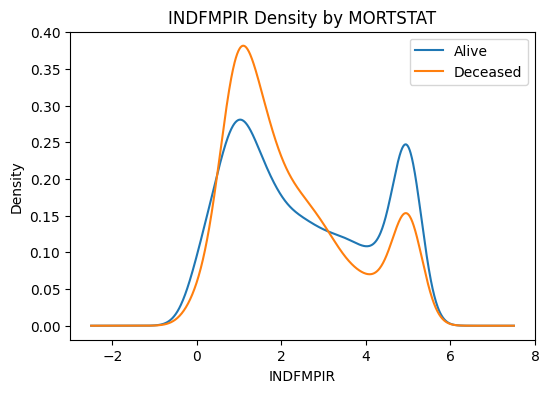

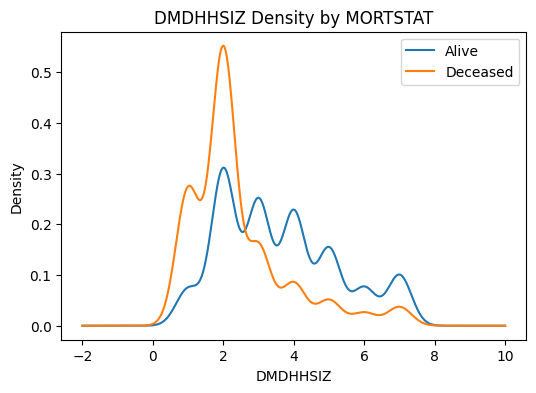

In [7]:
for col in ["RIDAGEYR", "INDFMPIR", "DMDHHSIZ"]:
    plt.figure(figsize=(6,4))
    df_model[df_model["MORTSTAT"] == 0][col].plot(kind="density", label="Alive")
    df_model[df_model["MORTSTAT"] == 1][col].plot(kind="density", label="Deceased")
    plt.title(f"{col} Density by MORTSTAT")
    plt.xlabel(col)
    plt.legend()
    plt.show()

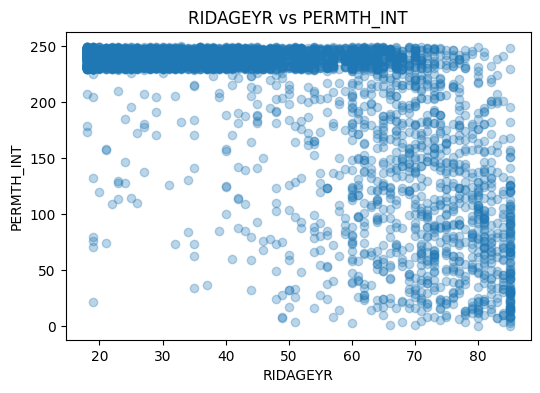

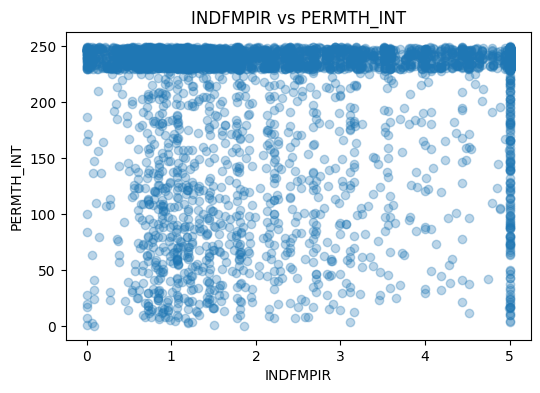

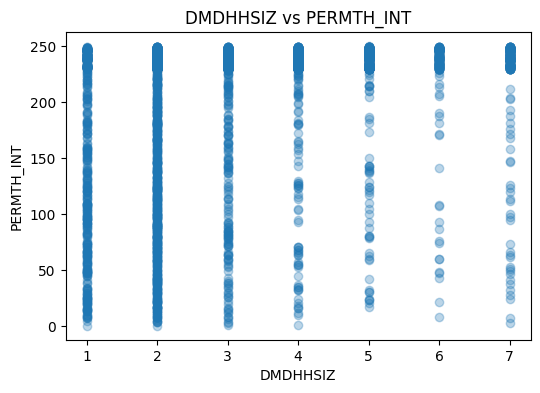

In [8]:
pairs = [("RIDAGEYR", "PERMTH_INT"),
         ("INDFMPIR", "PERMTH_INT"),
         ("DMDHHSIZ", "PERMTH_INT")]

for x, y in pairs:
    plt.figure(figsize=(6,4))
    plt.scatter(df_model[x], df_model[y], alpha=0.3)
    plt.title(f"{x} vs {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

The variable analysis suggests that age is the strongest predictor. The conditional density plots show a clear shift toward older ages among deceased participants. Poverty-income ratio and household size also differ somewhat by mortality status, but the separation is weaker. Scatterplots suggest that higher age is associated with shorter follow-up time.

In [9]:
X = df_model[["RIDAGEYR", "DMDMARTL", "INDFMPIR", "DMDHHSIZ", "DMDBORN"]]
y_class = df_model["MORTSTAT"]

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_features = ["RIDAGEYR", "INDFMPIR", "DMDHHSIZ"]
categorical_features = ["DMDMARTL", "DMDBORN"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline([
    ("prep", preprocessor),
    ("model", KNeighborsClassifier())
])

param_grid = {"model__n_neighbors": list(range(1, 31))}

grid_clf = GridSearchCV(
    knn_clf,
    param_grid,
    cv=5,
    scoring="accuracy"
)

grid_clf.fit(X_train, y_train)

print("Best k:", grid_clf.best_params_)
print("Best CV accuracy:", grid_clf.best_score_)

Best k: {'model__n_neighbors': 25}
Best CV accuracy: 0.8611574475255152


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

best_clf = grid_clf.best_estimator_
y_pred = best_clf.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.8656957928802589

Confusion matrix:
 [[808  60]
 [106 262]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91       868
         1.0       0.81      0.71      0.76       368

    accuracy                           0.87      1236
   macro avg       0.85      0.82      0.83      1236
weighted avg       0.86      0.87      0.86      1236



I used a k-Nearest Neighbors classifier to predict MORTSTAT. Because k-NN depends on distance, I standardized the numeric variables and encoded the categorical variables before fitting the model. I selected k using 5 fold cross validation over values from 1 to 30 and chose the value with the best validation accuracy which was 25. The final model performance on the test set was evaluated using accuracy, a confusion matrix, and classification metrics. Age appears to be the most influential predictor because it showed the strongest separation during EDA.

In [13]:
y_reg = df_model["PERMTH_INT"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

In [14]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = Pipeline([
    ("prep", preprocessor),
    ("model", KNeighborsRegressor())
])

param_grid_reg = {"model__n_neighbors": list(range(1, 31))}

grid_reg = GridSearchCV(
    knn_reg,
    param_grid_reg,
    cv=5,
    scoring="neg_mean_squared_error"
)

grid_reg.fit(X_train_r, y_train_r)

print("Best k:", grid_reg.best_params_)
print("Best CV score:", grid_reg.best_score_)

Best k: {'model__n_neighbors': 28}
Best CV score: -2253.8259556424937


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_reg = grid_reg.best_estimator_
y_pred_r = best_reg.predict(X_test_r)

print("RMSE:", mean_squared_error(y_test_r, y_pred_r) ** 0.5)
print("MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("R^2:", r2_score(y_test_r, y_pred_r))

RMSE: 50.718067203212065
MAE: 32.10136384650947
R^2: 0.43225394005115225


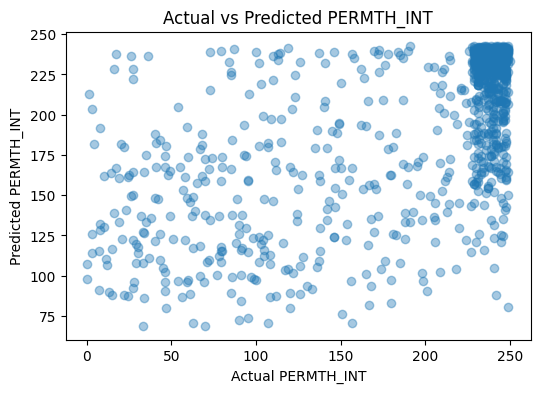

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(y_test_r, y_pred_r, alpha=0.4)
plt.xlabel("Actual PERMTH_INT")
plt.ylabel("Predicted PERMTH_INT")
plt.title("Actual vs Predicted PERMTH_INT")
plt.show()

I used a k-Nearest Neighbors regressor to predict PERMTH_INT. numeric predictors were standardized and categorical predictors were one-hot encoded. I selected k by cross-validation, choosing the value that minimized mean squared error with a limit so that k didn't get too large. Model performance was evaluated using RMSE, MAE, and R^2. Based on the EDA, age was expected to be the strongest predictor of follow xup time.

This type of model could be used to identify groups of patients with characteristics associated with higher mortality risk or shorter expected follow up time. For example, older individuals with lower income-related measures and smaller household size may be flagged for additional monitoring or preventive interventions, treatments, or lifestyle changes. However, there are important limitations. The model is based on observational data, so it identifies correlation rather than causal effects. It also relies on demographic and socioeconomic variables, which may reflect structural inequalities and could introduce fairness concerns if used without care. In addition, k-NN is sensitive to scaling, missing data handling, and the choice of k, and it may not perform as well when the relationship between predictors and outcomes is complex. Overall it is always important to remember that correlation does not always equal causation and this is just observational data. This data is also dated as it is now over 25 years old which is important to consider when observing. 